In [1]:
#import the most used things
print("importing...")
import deepchem as dc
import pandas as pd
import numpy as np

importing...


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
print("colecting data...")
tasks, data, transformers = dc.molnet.load_hopv(featurizer=dc.feat.RDKitDescriptors(), splitter = None)

colecting data...


ValueError: No Metadata found in the path C:\Users\wanne\AppData\Local\Temp\hopv-featurized\RDKitDescriptors\ScaffoldSplitter\NormalizationTransformer_transform_y_True\train_dir

In [4]:
#convert the dataset so that no more nan is present and selct the y-values of the homo gap toghether with the according wheigths
dataset = data[0]
#converting the train set
X = np.nan_to_num(dataset.X, copy=True, nan=0.0)
Y = dataset.y[:,[0]]
w = dataset.w[:,[0]]
ids = dataset.ids
Task = dataset.tasks[0]


#find al the positive values and delete them
to_del = []
for idx, value in enumerate(Y):
    
    if value[0] > 0:
        to_del.append(idx)


X = np.delete(X,to_del,0)
Y = np.delete(Y,to_del).reshape(-1, 1)
w = np.delete(w,to_del).reshape(-1, 1)
ids = np.delete(ids,to_del)

In [5]:
# we now that the positive values of the homo band gap are all the same value so we try to remove these
#add the cenverted data to new dataframe
new_data= dc.data.DiskDataset.from_numpy(X=X, y=Y, w=w, ids=ids, tasks = [Task])
print(new_data.tasks)

['HOMO']


In [6]:
#split the data in train and test samples
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(new_data)

In [7]:
# create the GPR model & fit the model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF


kernel = 1 * RationalQuadratic()
model = dc.models.SklearnModel(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100))

print("fitting model...")
model.fit(train_dataset)
print("model is fitted!")

#predict the test set
predicted = model.predict(test_dataset)

fitting model...


c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


model is fitted!


In [8]:
#calculate r2 score
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('Training set score:', model.evaluate(train_dataset, metric))
test_score= model.evaluate(test_dataset, metric)
print('Test set score:',test_score )

Training set score: {'pearson_r2_score': 1.0}
Test set score: {'pearson_r2_score': 0.048849043836439336}


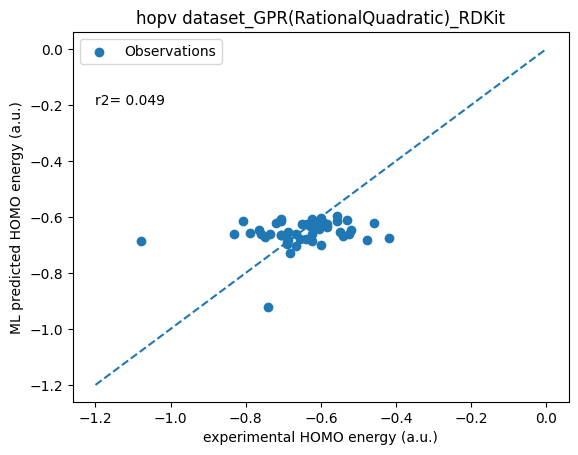

In [9]:
#convert tekst to string, so it can be depicted in matplotlib
number=list(test_score.values())[0]
text = "r2= "+ str(round(number,3))


#plot the data
import matplotlib.pyplot as plt

x=[-1.2,0]
y=[-1.2,0]
plt.plot(x, y, linestyle="dashed")
plt.scatter(test_dataset.y, predicted, label="Observations")
plt.legend()
plt.xlabel("experimental HOMO energy (a.u.)")
plt.ylabel("ML predicted HOMO energy (a.u.)")
plt.title("hopv dataset_GPR(RationalQuadratic)_RDKit")
plt.text(-1.2,-0.2,text)
plt.show()